In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import sys
sys.path.append('..')
import utils
from utils import one_hot
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

/Users/scrotti/Aptamer2025py/experiments/../sampling.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


File names for data

In [2]:
experiment_id = "Dop8V930"
round_ids = ["ARN", "R01", "R02N"]
dtype = torch.float32

Extract sequences and compute 1st and 2nd moment statistics

In [3]:
sequences = []
for round_id in round_ids:
    s = utils.sequences_from_file(experiment_id, round_id)
    sequences.append(s)
    print(f"Finished round {round_id}")

Finished round ARN
Finished round R01
Finished round R02N


In [6]:
import gc

def sequences_to_dfs(sequences):
    n_rounds = len(sequences)
    ts = range(n_rounds)
    sequences_unique, inverse_indices, counts = zip(*[
        torch.unique(seq_t, dim=0, return_inverse=True, return_counts=True)
        for seq_t in sequences])
    dfs = []
    for t in ts:
        df = pd.DataFrame(data={'seq': [sequences_unique[t][i,:] for i in range(len(sequences_unique[t]))], f'count_{t}': counts[t]})
        dfs.append(df)

    return dfs
    

def merge_sequence_dataframes(dfs):
    processed_dfs = []
    for df in dfs:
        df_copy = df.copy()
        df_copy['seq_key'] = df_copy['seq'].apply(lambda x: tuple(x))
        processed_dfs.append(df_copy)
    
    merged = processed_dfs[0]
    
    for df in processed_dfs[1:]:
        merged = merged.merge(df, on='seq_key', how='outer', suffixes=('', '_dup'))
        if 'seq_dup' in merged.columns:
            merged['seq'] = merged['seq'].combine_first(merged['seq_dup'])
            merged = merged.drop('seq_dup', axis=1)
    
    count_columns = [col for col in merged.columns if col.startswith('count_')]
    merged[count_columns] = merged[count_columns].fillna(0).astype(int)
    
    merged = merged.drop('seq_key', axis=1)

    gc.collect()
    
    return merged

def add_enrichments_(df_counts):
    n_rounds = len(df_counts.columns) - 1
    for t in range(1, n_rounds):
        enr = df_counts.iloc[:,t+1] / df_counts.iloc[:,t]
        df_counts[f'enrich_{t-1}_{t}'] = enr

def sequences_to_enrichment_df(sequences, verbose = True):
    if verbose:
        print("Building DataFrames for each round (1/3) ...")
    dfs = sequences_to_dfs(sequences)
    if verbose:
        print("Merging DataFrames (2/3) ...")
    df_counts = merge_sequence_dataframes(dfs)
    del dfs
    gc.collect()
    if verbose:
        print("Adding enrichments (3/3) ...")
    add_enrichments_(df_counts)

    gc.collect()

    return df_enrich

In [ ]:
df_enrich = sequences_to_enrichment_df(sequences)

Building DataFrames for each round (1/3) ...
Merging DataFrames (2/3) ...


In [ ]:
df_enrich.head(3)

In [ ]:
del sequences

In [ ]:
import gc
gc.collect()

## Learning

In [76]:
sequences_oh = [one_hot(seq).to(dtype=dtype) for seq in sequences]
total_reads = torch.Tensor([s.shape[0] for s in sequences_oh])

In [71]:
tr = tree.Tree()
tr.add_node(-1, name = "R01")
tr.add_node(0, name = "R02N")

selected_modes = torch.BoolTensor(
    [[1], [1]]
)

L, q = sequences_oh[0][0].shape

k = torch.zeros(L, q, dtype=dtype)
h = torch.zeros(L, q, dtype=dtype)
J = torch.zeros(L, q, L, q, dtype=dtype)
# J = utils.rand_coupling_matrix(L, q, dtype=dtype)

Ns0 = energy_models.IndepSites(k)
potts = energy_models.Potts(J, h)

ps = selex_distribution.MultiModeDistribution(potts, normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

In [73]:
device = torch.device('cpu')

batch_size = 10**6
data_loaders = [data_loading.SelexRoundDataLoader(seq_oh, batch_size=batch_size, device=device) for seq_oh in sequences_oh]
n_rounds = len(data_loaders) 

n_chains = 10**4
chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)
log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype)

In [74]:
callbacks = [callback.ConvergenceMetricsCallback(), callback.PearsonCovarianceCallback()]

In [77]:
n_sweeps = 10
lr = 0.02
target_pearson = 1
max_epochs = 500

training.train(model, data_loaders, total_reads, chains, n_sweeps, max_epochs, target_pearson, 
               lr=lr, callbacks=callbacks, log_weights=log_weights)

 0.00%[                                                                                     ] Epoch: 0/500 [00…

KeyboardInterrupt: 

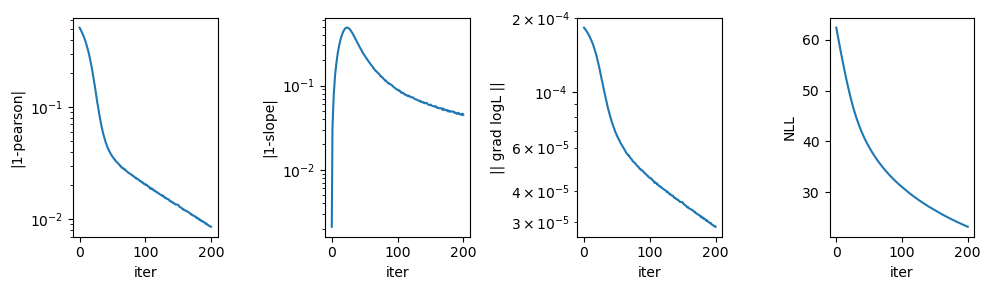

In [78]:
callbacks[0].plot();

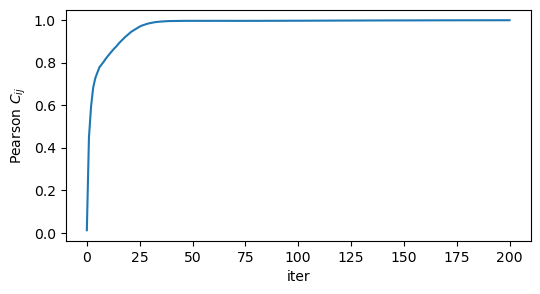

In [79]:
callbacks[1].plot();

## Group sequences by selection energy

In [ ]:
df_enrich["seq"].values

In [82]:
t = 1
logps_t = - model.selection_energy_at_round(one_hot(df_enrich["seq"].values), t)

AttributeError: 'numpy.ndarray' object has no attribute 'dim'

In [ ]:
plt.hist(logps_t)